In [33]:
import re
import pandas as pd
import matplotlib.pyplot as plt

pretrained = pd.read_csv('/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/figures/figure_4/pretrained.csv', header=None)
not_pretrained = pd.read_csv('/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/figures/figure_4/not_pretrained.csv', header=None)

In [34]:
pretrained = pretrained.astype(str)
not_pretrained = not_pretrained.astype(str)

In [35]:
import re
import pandas as pd

def extract_losses(df):
    """
    Extract epoch-based training and validation losses from log data.
    Records train loss only at the same points as validation loss (end of epochs),
    and includes the initial step as epoch 0.
    
    Args:
        df: DataFrame containing log text (assumes log text is in second column)
        
    Returns:
        tuple: (df_train, df_val) DataFrames with epoch-based losses
    """
    # Lists to store extracted data
    epochs = []
    train_losses = []
    val_losses = []
    
    # Track if we've found the first step (for epoch 0)
    first_step_found = False
    
    for idx, text in enumerate(df.iloc[:, 1]):  # assumes log text is in second column
        # First format: Progress: X/Y | Train Loss: Z
        progress_match = re.search(r"Progress:\s*(\d+)/(\d+)", text, re.IGNORECASE)
        if progress_match and not first_step_found:
            progress = int(progress_match.group(1))
            
            # Only record the very first step as epoch 0
            if progress == 1:
                train_match = re.search(r"Train\s*Loss:\s*([\d\.]+)", text, re.IGNORECASE)
                if train_match:
                    epochs.append(0)  # This is epoch 0
                    train_losses.append(float(train_match.group(1)))
                    first_step_found = True
        
        # Second format: Epoch: X/Y | Train loss: Z | Val loss: W
        # This is where we capture end-of-epoch data with both train and val loss
        epoch_match = re.search(r"Epoch:\s*(\d+)/\d+", text, re.IGNORECASE)
        if epoch_match:
            epoch = int(epoch_match.group(1))
            
            t_match = re.search(r"Train\s*loss:\s*([\d\.]+)", text, re.IGNORECASE)
            v_match = re.search(r"Val\s*loss:\s*([\d\.]+)", text, re.IGNORECASE)
            
            if t_match and v_match:
                epochs.append(epoch)
                train_losses.append(float(t_match.group(1)))
                val_losses.append(float(v_match.group(1)))
    
    # Create DataFrames with synchronized train and val losses
    df_train = pd.DataFrame({'Epoch': epochs, 'Train_Loss': train_losses})
    
    # For validation losses, we only have values for completed epochs (not epoch 0)
    if val_losses:
        # Filter out epoch 0 for validation dataframe
        val_epochs = [ep for ep in epochs if ep > 0]
        
        df_val = pd.DataFrame({
            'Epoch': val_epochs,
            'Val_Loss': val_losses
        })
    else:
        df_val = pd.DataFrame({'Epoch': [], 'Val_Loss': []})
    
    return df_train, df_val

# Usage
pretrained_train, pretrained_val = extract_losses(pretrained)
not_pretrained_train, not_pretrained_val = extract_losses(not_pretrained)

# Print summary for verification
print(f"Pretrained: {len(pretrained_train)} train points, {len(pretrained_val)} validation points")
print(f"Not pretrained: {len(not_pretrained_train)} train points, {len(not_pretrained_val)} validation points")

Pretrained: 7 train points, 7 validation points
Not pretrained: 7 train points, 7 validation points


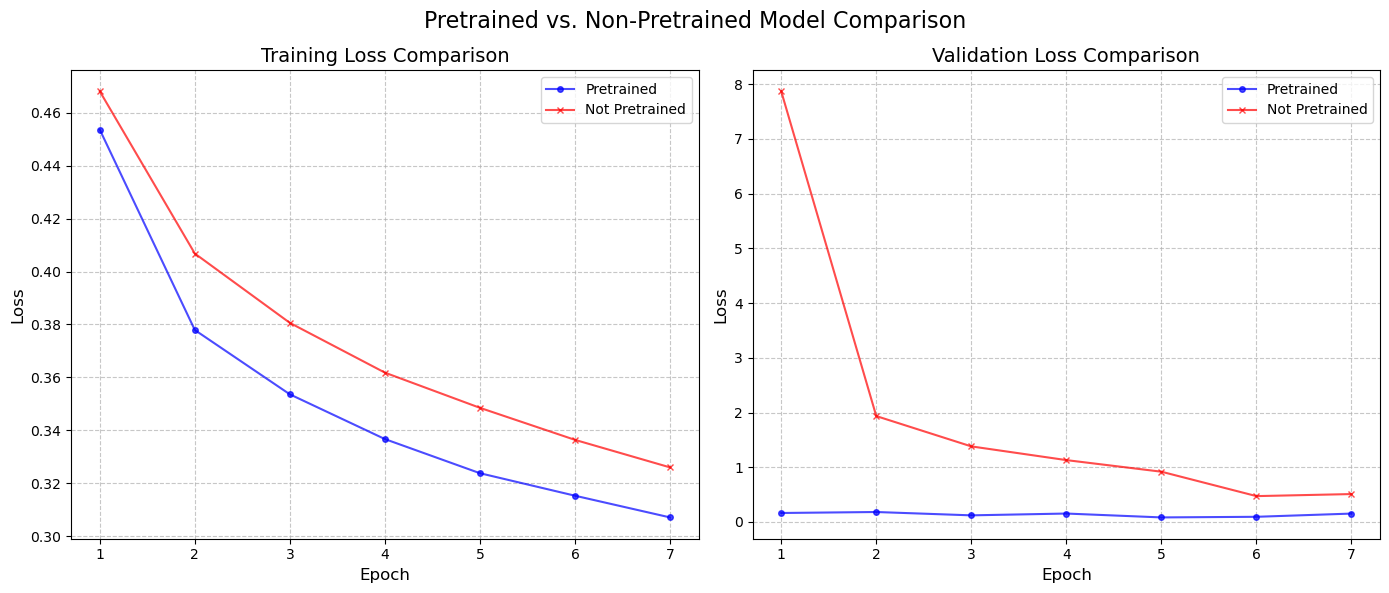

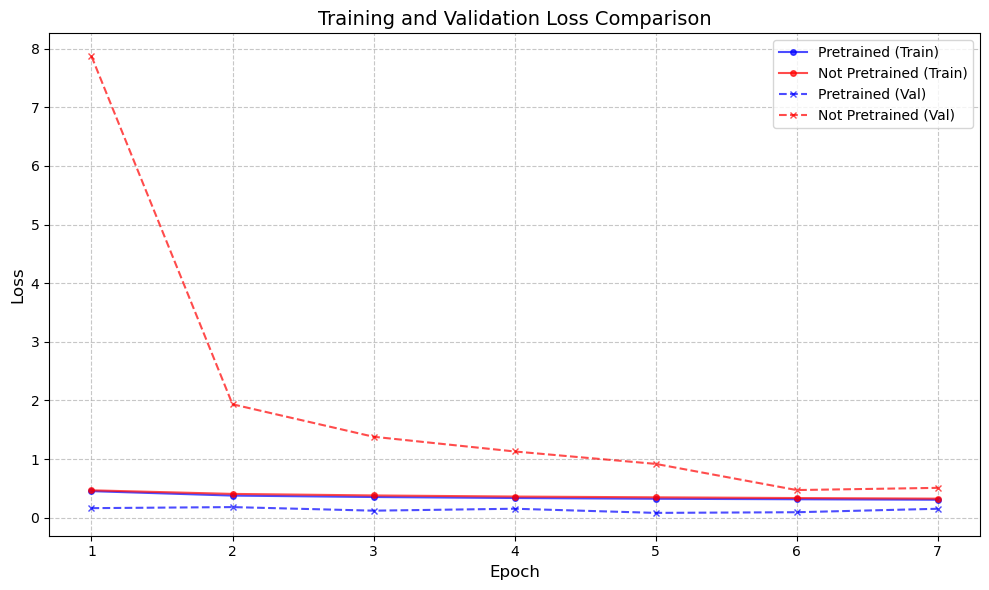

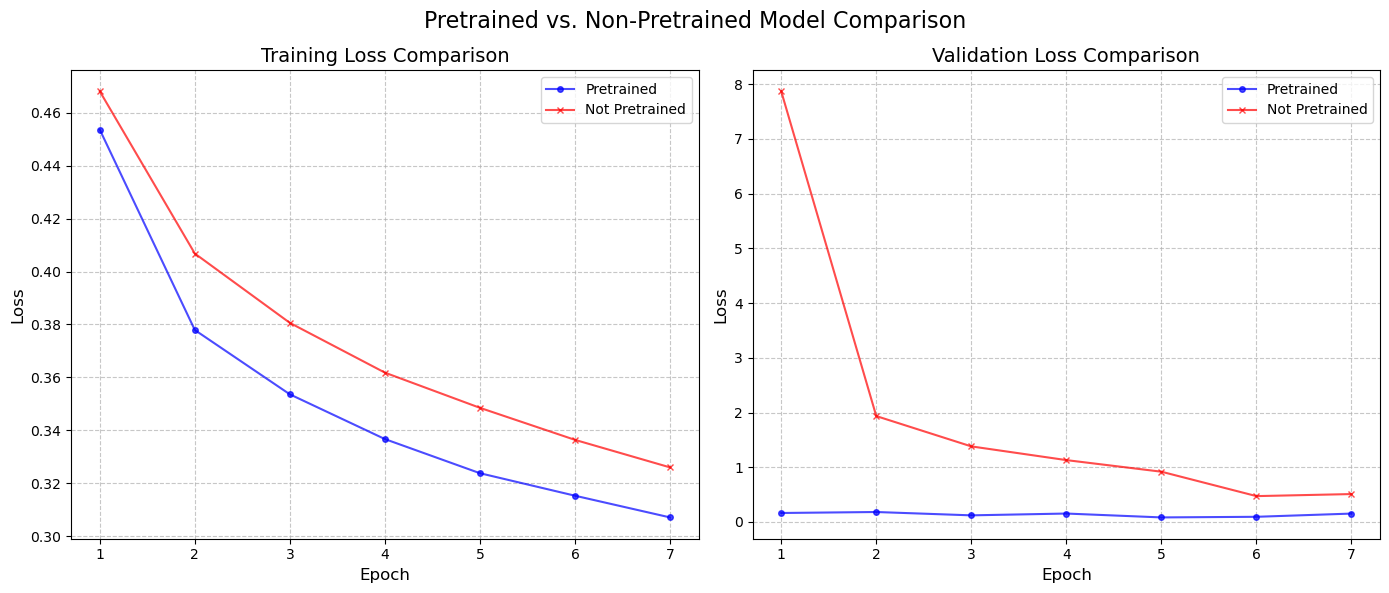

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_comparisons(pretrained_train, not_pretrained_train, pretrained_val, not_pretrained_val):
    """
    Create a plot comparing pretrained vs non-pretrained models for both train and validation losses.
    
    Parameters:
    -----------
    pretrained_train : DataFrame
        DataFrame with 'Epoch' and 'Train_Loss' columns for pretrained model
    not_pretrained_train : DataFrame
        DataFrame with 'Epoch' and 'Train_Loss' columns for non-pretrained model
    pretrained_val : DataFrame
        DataFrame with 'Epoch' and 'Val_Loss' columns for pretrained model
    not_pretrained_val : DataFrame
        DataFrame with 'Epoch' and 'Val_Loss' columns for non-pretrained model
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot training loss comparison
    ax1.plot(pretrained_train['Epoch'], pretrained_train['Train_Loss'], 
             label='Pretrained', color='blue', marker='o', markersize=4, linestyle='-', alpha=0.7)
    ax1.plot(not_pretrained_train['Epoch'], not_pretrained_train['Train_Loss'], 
             label='Not Pretrained', color='red', marker='x', markersize=4, linestyle='-', alpha=0.7)
    
    # Format the training loss plot
    ax1.set_title('Training Loss Comparison', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot validation loss comparison (if data exists)
    if not pretrained_val.empty and not not_pretrained_val.empty:
        ax2.plot(pretrained_val['Epoch'], pretrained_val['Val_Loss'], 
                 label='Pretrained', color='blue', marker='o', markersize=4, linestyle='-', alpha=0.7)
        ax2.plot(not_pretrained_val['Epoch'], not_pretrained_val['Val_Loss'], 
                 label='Not Pretrained', color='red', marker='x', markersize=4, linestyle='-', alpha=0.7)
        
        # Format the validation loss plot
        ax2.set_title('Validation Loss Comparison', fontsize=14)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Loss', fontsize=12)
        ax2.legend(fontsize=10)
        ax2.grid(True, linestyle='--', alpha=0.7)
    else:
        ax2.text(0.5, 0.5, 'No validation data available', 
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax2.transAxes, fontsize=12)
    
    # Add overall title and adjust layout
    plt.suptitle('Pretrained vs. Non-Pretrained Model Comparison', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    
    return fig

def plot_combined_losses(pretrained_train, not_pretrained_train, pretrained_val, not_pretrained_val):
    """
    Create a single plot with both training and validation losses for clearer comparison.
    
    Parameters are the same as plot_loss_comparisons.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot training losses
    ax.plot(pretrained_train['Epoch'], pretrained_train['Train_Loss'], 
            label='Pretrained (Train)', color='blue', marker='o', markersize=4, linestyle='-', alpha=0.7)
    ax.plot(not_pretrained_train['Epoch'], not_pretrained_train['Train_Loss'], 
            label='Not Pretrained (Train)', color='red', marker='o', markersize=4, linestyle='-', alpha=0.7)
    
    # Plot validation losses (if data exists)
    if not pretrained_val.empty and not not_pretrained_val.empty:
        ax.plot(pretrained_val['Epoch'], pretrained_val['Val_Loss'], 
                label='Pretrained (Val)', color='blue', marker='x', markersize=4, linestyle='--', alpha=0.7)
        ax.plot(not_pretrained_val['Epoch'], not_pretrained_val['Val_Loss'], 
                label='Not Pretrained (Val)', color='red', marker='x', markersize=4, linestyle='--', alpha=0.7)
    
    # Format the plot
    ax.set_title('Training and Validation Loss Comparison', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return fig

def adjust_epoch_scale(pretrained_train, not_pretrained_train, pretrained_val, not_pretrained_val):
    """
    Ensure both models have comparable epoch scales and create proper visualizations.
    This is useful if one model was trained for more epochs than the other.
    """
    # Create copies to avoid modifying originals
    pt_train = pretrained_train.copy()
    npt_train = not_pretrained_train.copy()
    pt_val = pretrained_val.copy()
    npt_val = not_pretrained_val.copy()
    
    # Get maximum epochs for each model
    pt_max_epoch = pt_train['Epoch'].max() if not pt_train.empty else 0
    npt_max_epoch = npt_train['Epoch'].max() if not npt_train.empty else 0
    
    # Check if the models have very different epoch ranges (one trained much longer)
    if (pt_max_epoch > 0 and npt_max_epoch > 0 and 
        (pt_max_epoch / npt_max_epoch > 2 or npt_max_epoch / pt_max_epoch > 2)):
        
        # Create a figure with two rows to show:
        # 1. Full range of epochs
        # 2. First few epochs for detailed early comparison
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))
        
        # Full range - Training loss
        axs[0, 0].plot(pt_train['Epoch'], pt_train['Train_Loss'], 
                     label='Pretrained', color='blue', marker='o', markersize=4, alpha=0.7)
        axs[0, 0].plot(npt_train['Epoch'], npt_train['Train_Loss'], 
                     label='Not Pretrained', color='red', marker='x', markersize=4, alpha=0.7)
        axs[0, 0].set_title('Training Loss - Full Range', fontsize=14)
        axs[0, 0].set_xlabel('Epoch', fontsize=12)
        axs[0, 0].set_ylabel('Loss', fontsize=12)
        axs[0, 0].legend(fontsize=10)
        axs[0, 0].grid(True, linestyle='--', alpha=0.7)
        
        # Full range - Validation loss
        if not pt_val.empty and not npt_val.empty:
            axs[0, 1].plot(pt_val['Epoch'], pt_val['Val_Loss'], 
                         label='Pretrained', color='blue', marker='o', markersize=4, alpha=0.7)
            axs[0, 1].plot(npt_val['Epoch'], npt_val['Val_Loss'], 
                         label='Not Pretrained', color='red', marker='x', markersize=4, alpha=0.7)
            axs[0, 1].set_title('Validation Loss - Full Range', fontsize=14)
            axs[0, 1].set_xlabel('Epoch', fontsize=12)
            axs[0, 1].set_ylabel('Loss', fontsize=12)
            axs[0, 1].legend(fontsize=10)
            axs[0, 1].grid(True, linestyle='--', alpha=0.7)
        else:
            axs[0, 1].text(0.5, 0.5, 'No validation data available', 
                         horizontalalignment='center', verticalalignment='center',
                         transform=axs[0, 1].transAxes, fontsize=12)
        
        # Early epochs - Training loss (first min(5, min_max_epoch) epochs)
        min_max_epoch = min(pt_max_epoch, npt_max_epoch)
        early_epoch_limit = min(5, min_max_epoch)
        
        # Filter data for early epochs
        pt_train_early = pt_train[pt_train['Epoch'] <= early_epoch_limit]
        npt_train_early = npt_train[npt_train['Epoch'] <= early_epoch_limit]
        
        axs[1, 0].plot(pt_train_early['Epoch'], pt_train_early['Train_Loss'], 
                     label='Pretrained', color='blue', marker='o', markersize=4, alpha=0.7)
        axs[1, 0].plot(npt_train_early['Epoch'], npt_train_early['Train_Loss'], 
                     label='Not Pretrained', color='red', marker='x', markersize=4, alpha=0.7)
        axs[1, 0].set_title(f'Training Loss - First {early_epoch_limit} Epochs', fontsize=14)
        axs[1, 0].set_xlabel('Epoch', fontsize=12)
        axs[1, 0].set_ylabel('Loss', fontsize=12)
        axs[1, 0].legend(fontsize=10)
        axs[1, 0].grid(True, linestyle='--', alpha=0.7)
        
        # Early epochs - Validation loss
        if not pt_val.empty and not npt_val.empty:
            pt_val_early = pt_val[pt_val['Epoch'] <= early_epoch_limit]
            npt_val_early = npt_val[npt_val['Epoch'] <= early_epoch_limit]
            
            axs[1, 1].plot(pt_val_early['Epoch'], pt_val_early['Val_Loss'], 
                         label='Pretrained', color='blue', marker='o', markersize=4, alpha=0.7)
            axs[1, 1].plot(npt_val_early['Epoch'], npt_val_early['Val_Loss'], 
                         label='Not Pretrained', color='red', marker='x', markersize=4, alpha=0.7)
            axs[1, 1].set_title(f'Validation Loss - First {early_epoch_limit} Epochs', fontsize=14)
            axs[1, 1].set_xlabel('Epoch', fontsize=12)
            axs[1, 1].set_ylabel('Loss', fontsize=12)
            axs[1, 1].legend(fontsize=10)
            axs[1, 1].grid(True, linestyle='--', alpha=0.7)
        else:
            axs[1, 1].text(0.5, 0.5, 'No validation data available', 
                         horizontalalignment='center', verticalalignment='center',
                         transform=axs[1, 1].transAxes, fontsize=12)
        
        plt.suptitle('Pretrained vs. Non-Pretrained Model Comparison', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        
        return fig
    else:
        # If epoch scales are similar, use the standard plot function
        return plot_loss_comparisons(pt_train, npt_train, pt_val, npt_val)

# Example usage:
# Regular comparison
fig1 = plot_loss_comparisons(pretrained_train, not_pretrained_train, pretrained_val, not_pretrained_val)

# Combined plot with train and val losses together
fig2 = plot_combined_losses(pretrained_train, not_pretrained_train, pretrained_val, not_pretrained_val)

# Adaptive plot that handles different epoch scales
fig3 = adjust_epoch_scale(pretrained_train, not_pretrained_train, pretrained_val, not_pretrained_val)

# plt.savefig('loss_comparison.png', dpi=300, bbox_inches='tight')
plt.show()